# EDA dan Preprocessing: Dataset Kartu Pokémon Asli vs. Palsu

Notebook ini bertujuan untuk melakukan Analisis Data Eksplorasi (EDA) dan Preprocessing pada dataset gambar kartu Pokémon untuk memahami karakteristik yang membedakan kartu asli (real) dan palsu (fake) sebelum tahap modeling.

Link Dataset: https://www.kaggle.com/datasets/ongshujian/real-and-fake-pokemon-cards/data

## 1. Import Library dan Persiapan Awal

Bagian ini berfungsi untuk mengimpor pustaka Python yang digunakan dalam analisis dan preprocessing gambar. Library utama yang digunakan adalah:
- **os, pandas, numpy**: manipulasi data dan sistem file.
- **matplotlib, seaborn**: visualisasi data.
- **PIL, cv2 (OpenCV)**: pemrosesan gambar.
- **tqdm**: progress bar.
- **scikit-learn**: encoding label dan pembagian data train-test.

In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
tqdm.pandas()
print('Library siap digunakan.')

Library siap digunakan.


## 2. Memuat Data dan Label

Bagian ini membaca file CSV label gambar dan menghubungkannya dengan path file gambar di folder `data/train/`. Kolom `label` diubah menjadi format teks ('real' dan 'fake').

In [11]:
train_img_path = 'data/train/'
train_labels_path = 'data/train_labels.csv'

labels_df = pd.read_csv(train_labels_path)
labels_df['id'] = labels_df['id'].astype(str)
labels_df['filepath'] = labels_df['id'].apply(lambda x: os.path.join(train_img_path, x + '.jpg'))
labels_df['label'] = labels_df['label'].map({0: 'real', 1: 'fake'})
df = labels_df[['filepath', 'label']].copy().sample(frac=1, random_state=42).reset_index(drop=True)
print('DataFrame berhasil dimuat dengan kolom filepath dan label.')
df.head()

DataFrame berhasil dimuat dengan kolom filepath dan label.


,filepath,label
0,data/train/328.jpg,fake
1,data/train/34.jpg,real
2,data/train/16.jpg,real
3,data/train/315.jpg,fake
4,data/train/58.jpg,real


## 3. EDA: Analisis Data dan Visualisasi

Tahap ini digunakan untuk memahami struktur dataset, distribusi label, serta melihat beberapa contoh gambar kartu Pokémon asli dan palsu.

C:\Users\Hibino\AppData\Local\Temp\ipykernel_7460\2971032103.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='pastel')


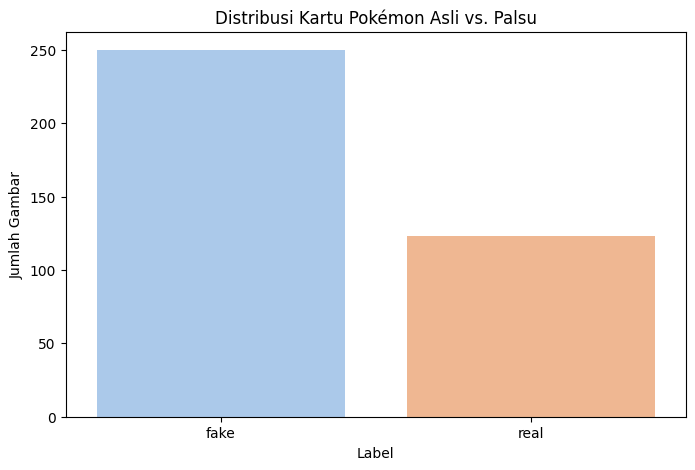

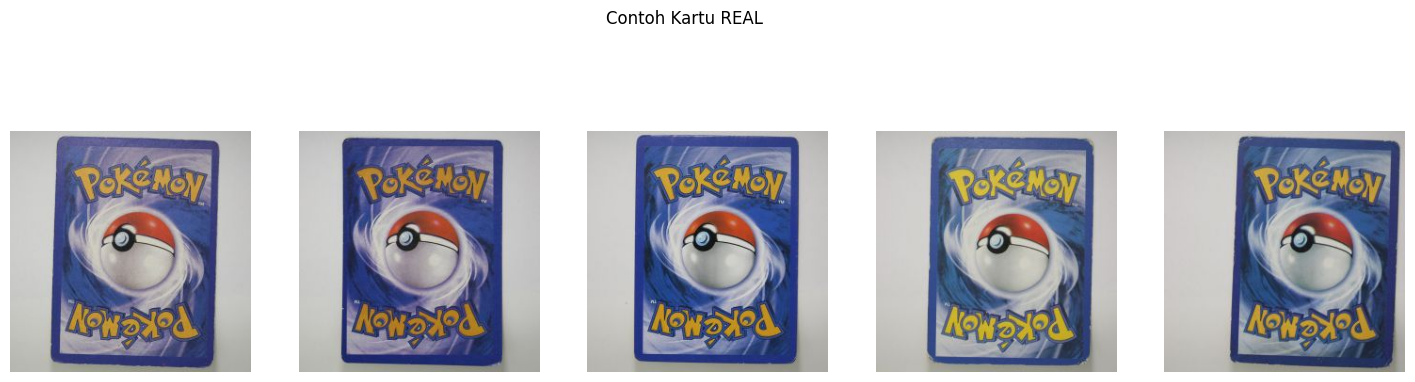

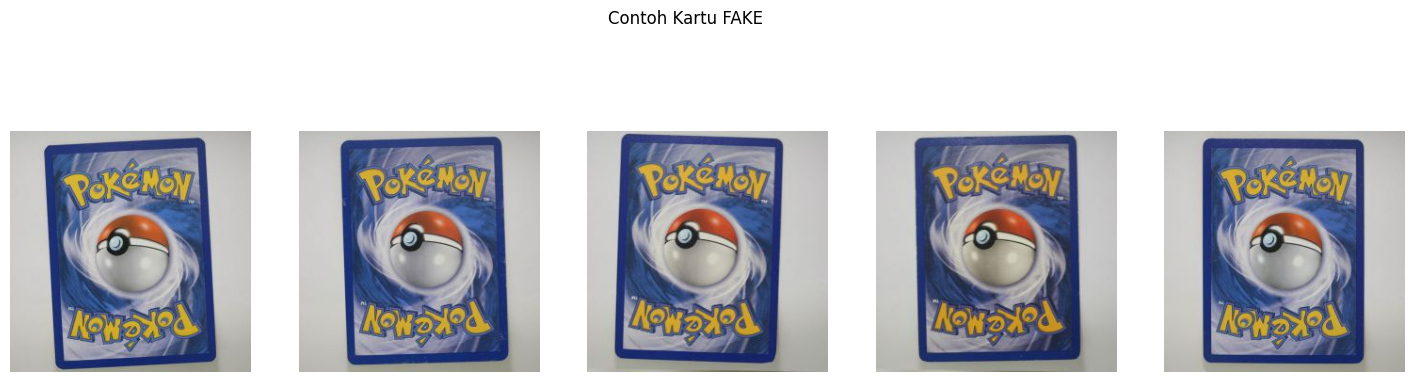

In [12]:
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df, palette='pastel')
plt.title('Distribusi Kartu Pokémon Asli vs. Palsu')
plt.xlabel('Label')
plt.ylabel('Jumlah Gambar')
plt.show()

def tampilkan_contoh(label_name, jumlah=5):
    plt.figure(figsize=(18, 5))
    sample_paths = df[df['label'] == label_name]['filepath'].sample(jumlah, random_state=1).values
    for i, path in enumerate(sample_paths):
        plt.subplot(1, jumlah, i+1)
        plt.imshow(Image.open(path))
        plt.axis('off')
    plt.suptitle(f'Contoh Kartu {label_name.upper()}')
    plt.show()

tampilkan_contoh('real')
tampilkan_contoh('fake')

## 4. Feature Extraction: Color Histogram

Pada tahap ini setiap gambar diubah menjadi representasi histogram warna. Histogram menggambarkan distribusi intensitas warna merah, hijau, dan biru (RGB) yang dapat membantu membedakan karakteristik visual antara kartu asli dan palsu.

In [13]:
def extract_color_histogram(image_path, bins=(8, 8, 8)):
    image = cv2.imread(image_path)
    if image is None:
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0,256,0,256,0,256])
    cv2.normalize(hist, hist)
    return hist.flatten()

df['hist_features'] = df['filepath'].progress_apply(extract_color_histogram)
df = df.dropna(subset=['hist_features']).reset_index(drop=True)
print('Ekstraksi fitur Color Histogram selesai.')

100%|██████████| 373/373 [00:00<00:00, 1856.12it/s]

Ekstraksi fitur Color Histogram selesai.


### Visualisasi Histogram Warna untuk Kartu Asli dan Palsu

Visualisasi ini menampilkan dua gambar (asli dan palsu) serta histogram warna RGB masing-masing untuk melihat perbedaan distribusi warnanya.

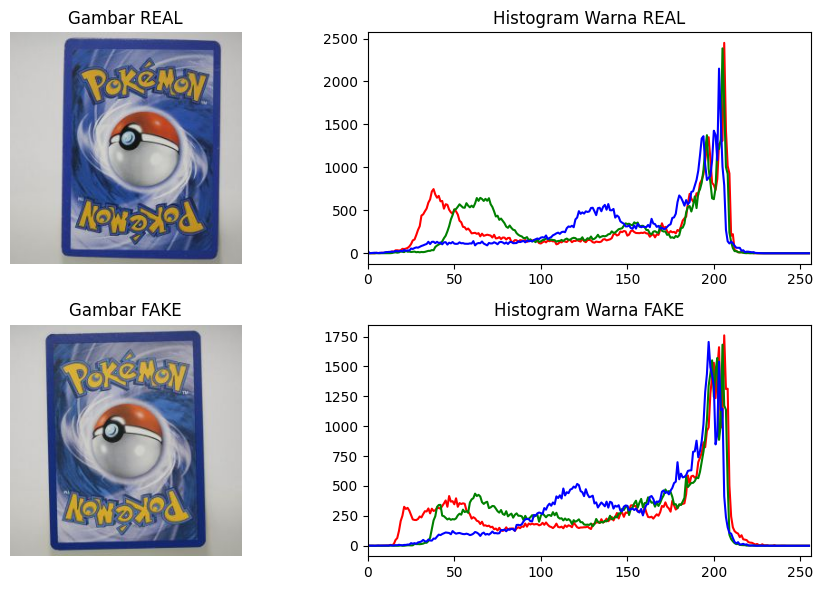

In [14]:
def show_histogram_comparison(real_path, fake_path):
    plt.figure(figsize=(14, 6))
    for idx, (path, title) in enumerate(zip([real_path, fake_path], ['REAL', 'FAKE'])):
        img = cv2.imread(path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 3, 3*idx+1)
        plt.imshow(img_rgb)
        plt.title(f'Gambar {title}')
        plt.axis('off')
        plt.subplot(2, 3, 3*idx+2)
        for i, col in enumerate(('r','g','b')):
            hist = cv2.calcHist([img_rgb],[i],None,[256],[0,256])
            plt.plot(hist,color=col)
        plt.title(f'Histogram Warna {title}')
        plt.xlim([0,256])
    plt.tight_layout()
    plt.show()

real_path = df[df['label']=='real']['filepath'].iloc[0]
fake_path = df[df['label']=='fake']['filepath'].iloc[0]
show_histogram_comparison(real_path, fake_path)

## 5. Feature Extraction Tambahan: Edge dan Corner Detection

Selain warna, pola tepi dan sudut pada kartu juga dapat menjadi pembeda antara kartu asli dan palsu. Pada tahap ini dilakukan dua teknik:
- **Edge Detection (Canny)**: mendeteksi garis tepi berdasarkan perubahan intensitas.
- **Corner Detection (Harris)**: mendeteksi sudut yang sering muncul pada pola cetakan atau tepi gambar.

In [15]:
def extract_edge_corner_features(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edge_density = np.sum(edges > 0) / edges.size
    corners = cv2.cornerHarris(np.float32(gray), 2, 3, 0.04)
    corner_density = np.sum(corners > 0.01 * corners.max()) / corners.size
    return edge_density, corner_density

df[['edge_density', 'corner_density']] = pd.DataFrame(df['filepath'].progress_apply(extract_edge_corner_features).tolist())
print('Ekstraksi fitur Edge dan Corner selesai.')

100%|██████████| 373/373 [00:00<00:00, 757.52it/s]

Ekstraksi fitur Edge dan Corner selesai.


### Visualisasi Edge dan Corner Detection

Bagian ini menampilkan hasil deteksi tepi dan sudut dari satu gambar kartu asli dan satu kartu palsu. Perbedaan jumlah tepi dan sudut dapat menunjukkan perbedaan kualitas cetakan.

Kartu Asli:


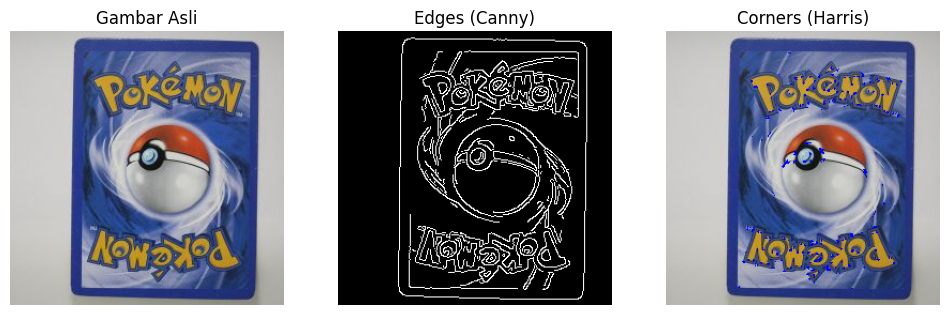

Kartu Palsu:


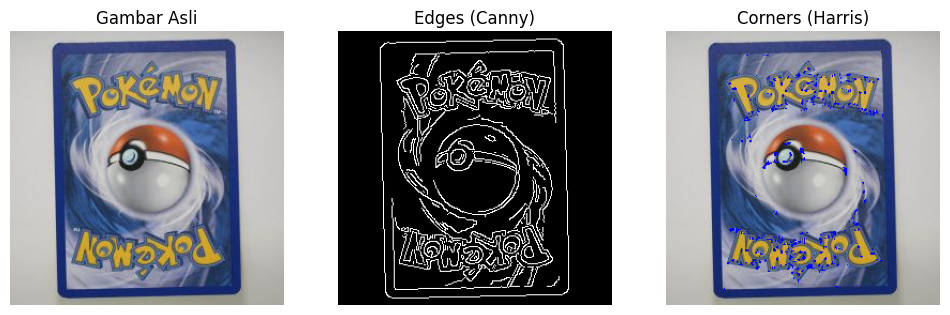

In [16]:
def visualize_edges_corners(path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    corners = cv2.cornerHarris(np.float32(gray), 2, 3, 0.04)
    img_corners = img.copy()
    img_corners[corners > 0.01 * corners.max()] = [255, 0, 0]

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Gambar Asli')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(edges, cmap='gray')
    plt.title('Edges (Canny)')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(img_corners, cv2.COLOR_BGR2RGB))
    plt.title('Corners (Harris)')
    plt.axis('off')
    plt.show()

print('Kartu Asli:')
visualize_edges_corners(real_path)
print('Kartu Palsu:')
visualize_edges_corners(fake_path)

## 6. Gabungkan Semua Fitur dan Encode Label

Semua fitur yang telah diekstraksi (histogram warna, edge density, dan corner density) digabungkan menjadi satu matriks fitur. Label dikonversi menjadi bentuk numerik agar bisa digunakan dalam model machine learning.

In [17]:
X_hist = np.array(df['hist_features'].tolist())
extra_features = df[['edge_density', 'corner_density']].values
X_combined = np.hstack([X_hist, extra_features])

le = LabelEncoder()
y = le.fit_transform(df['label'])
print(f'Fitur gabungan siap digunakan. Bentuk X: {X_combined.shape}')

Fitur gabungan siap digunakan. Bentuk X: (373, 514)


## 7. Train-Test Split dan Penyimpanan Data

Tahap terakhir adalah membagi data menjadi data train dan test, kemudian menyimpannya dalam format `.npz` agar siap digunakan untuk tahap modeling selanjutnya.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42, stratify=y)
print(f'Train: {X_train.shape}, Test: {X_test.shape}')

np.savez('pokemon_features_ready.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
print('Data fitur siap digunakan dan telah disimpan dalam file pokemon_features_ready.npz.')

Train: (298, 514), Test: (75, 514)
Data fitur siap digunakan dan telah disimpan dalam file pokemon_features_ready.npz.


## 8. Kesimpulan

Notebook ini mencakup seluruh tahap awal pemrosesan dataset gambar Pokémon:

1. **EDA** untuk memahami distribusi dan karakteristik data.
2. **Preprocessing** dengan resizing dan normalisasi.
3. **Feature Extraction** menggunakan Color Histogram, Edge, dan Corner Detection.
4. **Data Preparation** dengan encoding dan pembagian train-test.

Dataset kini siap digunakan untuk eksperimen model klasifikasi seperti Logistic Regression, SVM, Random Forest, atau CNN.